In [1]:
import geopandas as gpd
import leafmap
from shapely.ops import unary_union
from shapely.geometry import Point, mapping, box, shape
import shapely
import json
import os
import numpy as np
import matplotlib.pyplot as plt


from typing import List
import geopandas as gpd
import pandas as pd
import os
import rasterio
import numpy as np
import argparse
from tqdm import tqdm
tqdm.pandas()

import sys
sys.path.append("..")

os.getcwd()
os.chdir("..")
root = os.path.dirname(os.getcwd())
# root = root + "/workspaces/mine-segmentation" # uncomment when running in Lightning Studios
root

'/Users/simonjasansky/programming/mine-segmentation'

In [69]:
from src.data.get_satellite_images import ReadSTAC

In [70]:
# INPUT DATASET
filtered_dataset = root + "/data/processed/mining_tiles_with_masks_and_bounding_boxes_filtered.gpkg"
# OUTPUT DATASET
test_dataset_annotations = root + "/data/raw/mining_tiles_test_annotations.gpkg"

In [71]:
# load the filtered dataset
tiles = gpd.read_file(filtered_dataset, layer="tiles")
polygons = gpd.read_file(filtered_dataset, layer="polygons")

# only the test data
tiles = tiles[tiles["split"] == "test"]
polygons = polygons[polygons["tile_id"].isin(tiles["tile_id"])]

In [73]:
if not os.path.exists(test_dataset_annotations):
    tiles.to_file(test_dataset_annotations, layer="tiles", driver="GPKG")
    polygons.to_file(test_dataset_annotations, layer="polygons_original", driver="GPKG")

    # create a new layer for the annotated polygons, which is the same as polygons, but the geometry is empty
    polygons_annotated = polygons.copy()
    polygons_annotated["geometry"] = None
    polygons_annotated.to_file(test_dataset_annotations, layer="polygons_annotated", driver="GPKG")
    print("File created")
else:
    print("File already exists")

File created


# Validate the test tiles
The aim is to visualize each tile and its mask in the notebook. 
Then, a new polygon is drawn according to my judgement, where the mine actually is. 
This new corrected polygon must then be saved. 
The framework used for this is leafmap. 

# USER INTERFACE

### REFRESH TILE

In [92]:
# load the dataset
tiles = gpd.read_file(test_dataset_annotations, layer="tiles")
polygons = gpd.read_file(test_dataset_annotations, layer="polygons_original")
polygons_annotated = gpd.read_file(test_dataset_annotations, layer="polygons_annotated")

# get the first tile for which the geometry is None
tile = polygons_annotated[polygons_annotated["geometry"].isna()].iloc[0]

# get index of the tile
index = polygons_annotated[polygons_annotated["geometry"].isna()].index[0]

print(f"Tile index: {index}, Tile ID: {tile['tile_id']}")

Tile index: 2, Tile ID: 62


### REVIEW

In [200]:
# plot that tile on a map
m = leafmap.Map(
    center=[tiles.geometry.centroid.y.iloc[index], tiles.geometry.centroid.x.iloc[index]], 
    zoom=20,
    height="1000px"
)

# visualize the tile boundaries
style_tile = {
    "stroke": True,
    "color": "orange",
    "weight": 2,
    "opacity": 1,
    "fill": False,
}

style_polygon = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
    "fillOpacity": 0.1,
}

m.add_gdf(tiles.iloc[index:index+1,:], layer_name="tiles", style=style_tile)

multipolygon = polygons.iloc[index:index+1,:]

polygon_list = list(multipolygon.geometry.values[0].geoms)

for polygon in polygon_list:
    m.edit_vector(
        shapely.to_geojson(polygon), 
        layer_name="polygons_original", 
        style=style_polygon, 
        id="polygons_original"
    )

# get the url of the S2 image
s2_name = tiles.iloc[index:index+1,:].s2_tile_id.values[0]
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
stac_reader = ReadSTAC(api_url)
bounds = tiles.iloc[index:index+1,:].geometry.bounds.values[0]
item = stac_reader.get_item_by_name(s2_name, bbox=bounds)

m.add_cog_layer(item.assets["visual"].href, name="Sentinel-2")

m

Map(center=[41.24997309979503, -117.24999993820116], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [201]:
len(polygon_list)

17

In [202]:
m.save_draw_features("/Users/simonjasansky/programming/mine-segmentation/notebooks/data/draw_features.gpkg")
# load the just saved features
draw_features = gpd.read_file("/Users/simonjasansky/programming/mine-segmentation/notebooks/data/draw_features.gpkg")
draw_features

,geometry
0,"POLYGON ((-117.24947 41.19051, -117.24947 41.1..."
1,"POLYGON ((-117.25012 41.19688, -117.25009 41.1..."
2,"POLYGON ((-117.25716 41.21024, -117.25726 41.2..."
3,"POLYGON ((-117.22789 41.22789, -117.22789 41.2..."
4,"POLYGON ((-117.18273 41.16584, -117.18283 41.1..."
5,"POLYGON ((-117.21202 41.18848, -117.21211 41.1..."
6,"POLYGON ((-117.22727 41.23159, -117.22794 41.2..."
7,"POLYGON ((-117.17997 41.24212, -117.17997 41.2..."
8,"POLYGON ((-117.17997 41.24212, -117.17997 41.2..."
9,"POLYGON ((-117.23237 41.27395, -117.23185 41.2..."


# SAVE FEATURES

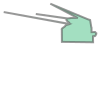

In [188]:
m.save_draw_features("/Users/simonjasansky/programming/mine-segmentation/notebooks/data/draw_features.gpkg")
# load the just saved features
draw_features = gpd.read_file("/Users/simonjasansky/programming/mine-segmentation/notebooks/data/draw_features.gpkg")

# convert to multipolyon
output = draw_features["geometry"].unary_union
output

In [164]:
polygons_annotated = gpd.read_file(test_dataset_annotations, layer="polygons_annotated")
polygons_annotated.loc[index, "geometry"] = output
polygons_annotated.to_file(test_dataset_annotations, layer="polygons_annotated", driver="GPKG")
polygons_annotated

,tile_id,geometry
0,29,"MULTIPOLYGON (((-129.79274 57.7229, -129.78853..."
1,34,"MULTIPOLYGON (((-122.25552 55.61852, -122.2405..."
2,62,"MULTIPOLYGON (((-117.24335 41.18398, -117.2423..."
3,64,None
4,81,None
...,...,...
115,2851,None
116,2911,None
117,2952,None
118,2956,None


# CAUTION: Remove the just annotated feature

In [85]:
# polygons_annotated = gpd.read_file(test_dataset_annotations, layer="polygons_annotated")
# polygons_annotated.loc[index, "geometry"] = None
# polygons_annotated.to_file(test_dataset_annotations, layer="polygons_annotated", driver="GPKG")
# polygons_annotated

,tile_id,geometry
0,29,None
1,34,None
2,62,None
3,64,None
4,81,None
...,...,...
115,2851,None
116,2911,None
117,2952,None
118,2956,None
